In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext notexbook
%texify

#### Strategy

- Collect data from 7 species experiments with all probes mixed in during FISHing and some dual combination experiments
- Annotate bouding boxes using LabelImg tool around the regions of signal based on the matrix of probes
- Load the boxes and save each one corresponding to the stack as text files
- Mark a bbox for the background signal on each image near the barcode region on the image
- Load the boxes and extract the 4 dimensional signal regions.
- Smoothen the regions to extract the regions of interest.
- Randomly sample from the regions outside the bboxes to get background data.
- Used the clean data to build a supervised classifier using test-train split of the above data
- Evaluate the performance on a new image, that is manually annotated for ROI
- Run algo on the stack of full images to see performance and do the figures needed for Fig8

##### Images collected from following experiments

1. **EXP-22-BV6188 AST FISH 220201** __*E.coli*__ upper and __*K.pneumoniae*__ lower
2. **EXP-22-BV6189 AST FISH 220202** __*P.aeurginosa*__ upper and __*E.faecalis*__ lower
3. **EXP-22-BV6190 AST FISH 220203** __*A.baumanii*__ upper and __*P.mirbalis*__ lower
4. **EXP-22-BV6191 AST FISH 220204** __*S.aureus*__ upper and __*S.aureus*__ lower
5. **EXP-22-BZ0300 AST FISH 220422** Mixed __*E.coli*__ and __*E.faecalis*__
6. **EXP-22-BV6194 AST FISH 220210** Mixed __*K.pneumoniae*__ and __*S.aureus*__
7. **EXP-22-BV6196 AST FISH 220214** Mixed __*P.aeruginosa*__ and __*A.baumanii*__
8. **EXP-22-BZ0313 AST FISH 220629** Mixed __*P.mirbalis*__ and __*E.coli*__

##### Position numbers collected from each experiment

1. **EXP-22-BV6188** __*E.coli*__ **Pos57** , and __*K.Pneumoniae*__ **Pos118**

2. **EXP-22-BV6189** __*P.aeruginosa*__ **Pos62** and __*E.faecalis*__ **Pos115**

3. **EXP-22-BV6190** __*A.baumanii*__ **Pos115** and __*P.mirbalis*__ **Pos167**

4. **EXP-22-BV6191** __*S.aureus*__ **Pos119**

5. **EXP-22-BZ0300** __Mixed__ __*Ecoli*__ and __*E.faecalis*__ **Pos114**, **Pos122**

6. **EXP-22-BV6194** __Mixed__ __*K.penumoniae*__ and __*S.aureus*__ **Pos107**, **Pos276**, **Pos271**

7. **EXP-22-BV6196** __Mixed__ __*P.aeruginosa*__ and __*A.baumanii*__ **Pos118**, **Pos262**,

8. **EXP-22-BZ0313** __Mixed__ __*P.mirbalis*__ and __*E.coli*__ **Pos124**


For each species draw bouding boxes using LabelImg tool on the image corresponding to the channels shown below.



##### Imports

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from pathlib import Path
import seaborn as sns
%matplotlib qt


In [3]:
labels = {
    0: 'ecoli',
    1: 'kpneumoniae',
    2: 'paeruginosa',
    3: 'efaecalis',
    4: 'abaumanii',
    5: 'pmirbalis',
    6: 'saureus',
    7: 'background'
}

species_to_labels = {
    'ecoli': 0,
    'kpneumoniae': 1,
    'paeruginosa': 2,
    'efaecalis': 3,
    'abaumanii': 4,
    'pmirbalis': 5,
    'saureus': 6,
    'background': 7
}

In [4]:
['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis',
                 'abaumanii', 'pmirbalis', 'saureus']

['ecoli',
 'kpneumoniae',
 'paeruginosa',
 'efaecalis',
 'abaumanii',
 'pmirbalis',
 'saureus']

In [6]:
root_dir = '/mnt/sda2/Praneeth/ASTFISH/'
DATASET_PATH = root_dir + 'data/EXP-22-BP0394 Analysis code data and models/data/fish_data/'
SPECIES_NAMES = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis',
                 'abaumanii', 'pmirbalis', 'saureus',
                 'mixed_kpneumoniae_saureus', 'mixed_kpneumoniae_saureus_1',
                 'mixed_kpneumoniae_saureus_2', 
                 'mixed_ecoli_efaecalis_1','mixed_ecoli_efaecalis_2',
                'mixed_paeruginosa_abaumanii','mixed_paeruginosa_abaumanii_1', 
                 'mixed_pmirbalis_ecoli_3']
FLUOR_PATHS = [DATASET_PATH + species for species in SPECIES_NAMES]

In [7]:
class FISHDataset:
    
    def __init__(self, directory,
                 fish_channel_names=['alexa488', 'cy3', 'cy5', 'texasred'], labels=None
                ):
        if type(directory) == str:
            self.directory = Path(directory)
        else:
            self.directory = directory
        self.channel_names = fish_channel_names
        
        self.labels = labels
        self.normalization_vector = None
        
        self.images = {}
        
        self.labels_file = self.directory / 'labels.txt'
        
        self.normalization_file = self.directory / 'barcode.txt'
        #print(self.normalization_file)
        if self.labels_file.is_file():
            self.bbox_data = np.loadtxt(self.labels_file)
        else:
            self.bbox_data = np.array([])
            
        if self.normalization_file.is_file():
            self.norm_bbox_data = np.loadtxt(self.normalization_file)
            if self.norm_bbox_data.ndim == 1:
                self.norm_bbox_data = self.norm_bbox_data[None, :]
        else:
            self.norm_bbox_data = np.array([])
            
        
        for channel in self.channel_names:
            img_path = self.directory / str(channel) / "img_000000000.tiff"
            image = io.imread(img_path)
            self.images[channel] = image
            self.height, self.width = image.shape
                        
        self.colors = {
            'alexa488': 'b',
            'cy3': 'g',
            'cy5': 'm',
            'texasred': 'r',
        }
        self.bbox_xywh = {} # keys: 'species'and values are [# (x, y, w, h)]
        for label, species in self.labels.items():
            self.bbox_xywh[species] = []
            
        for box in self.bbox_data:
            species = self.labels[int(box[0])]
            box = box[1:]
            upper_left_x = (box[0] - box[2] / 2) * self.width
            upper_left_y = (box[1] - box[3] / 2) * self.height
            self.bbox_xywh[species].append(
                [int(upper_left_x),
                 int(upper_left_y),
                 int(box[2] * self.width),
                 int(box[3] * self.height)]
            )
        
        self.norm_xywh = []
        for box in self.norm_bbox_data:
            box = box[1:]
            upper_left_x = (box[0] - box[2] / 2) * self.width
            upper_left_y = (box[1] - box[3] / 2) * self.height
            width = int(box[2] * self.width)
            height = int(box[3] * self.height)
            
            self.norm_xywh.append([
                int(upper_left_x),
                int(upper_left_y),
                width,
                height,
            ])
        # take the average of the images stacked here already
        images_stack_norm = [self.images[channel].copy() for channel in self.channel_names]
        images_stack_norm = np.stack(images_stack_norm)
        # loop over and average the normalization data
        if len(self.norm_xywh) != 0:
            normalization_pool = []
            for bbox in self.norm_xywh:
                normalization_signal = images_stack_norm[:, bbox[1]: bbox[1] + bbox[3],
                                                            bbox[0]: bbox[0] + bbox[2]]
                normalization_signal_reshape = normalization_signal.reshape(len(self.channel_names), -1)
                #print(normalization_signal.shape, bbox, normalization_signal_reshape.shape)
                normalization_mean = np.mean(normalization_signal_reshape, axis=1)
                #print(normalization_mean, normalization_mean.shape)
                normalization_pool.append(normalization_mean)
                
            self.normalization_pool = normalization_pool
            self.normalization_vector = np.mean(np.stack(self.normalization_pool), axis=0)
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, channel_name):
        return self.images[channel_name]
    
    def getData(self, img_operations=None):
        # construct a 4 dimensional data vector for 
        # each of the datapoint inside the bbox, and also the background
        data = {} # has keys 'signal' and 'background'
        for species, species_bbox_list in self.bbox_xywh.items():
            if species_bbox_list != []:
                # key is species
                # now iterate over the bboxes and collect values from all 4 channels
                mask = np.zeros((self.height, self.width), dtype=bool)
                for bbox in species_bbox_list:
                    mask[bbox[1]: bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]] = 1
                #print(mask.shape)
                
                images_stack = [self.images[channel].copy() for channel in self.channel_names]
                images_stack = np.stack(images_stack)
                
                #print(images_stack.shape)
                species_data = []
                for bbox in species_bbox_list:
                    #print("Bbox", bbox)
                    signal_stack = images_stack[:, bbox[1]: bbox[1] + bbox[3], bbox[0]: bbox[0]+ bbox[2]]
                    #signal_stack_mean = images_stack[:, mask == 1]
                    #print("signal stack" , signal_stack.shape)
                    signal_stack_mean = np.mean(signal_stack, axis=2)
                    #print("Signal mean horizontal", signal_stack_mean.shape)
                    species_data.append(signal_stack_mean)
                    
                #print("Species_stack shape:", species, np.hstack(species_data).shape)
                data[species]= np.hstack(species_data)
                
        if 'background' not in data:
            # create mask with all the bboxes of all the species in the bboxlist
            mask = np.zeros((self.height, self.width), dtype=bool)
            for species, species_bbox_list in self.bbox_xywh.items():
                for bbox in species_bbox_list:
                    mask[bbox[1]: bbox[1] + bbox[3], bbox[0] : bbox[0] + bbox[2]] = 1
                    
            images_stack = [self.images[channel].copy() for channel in self.channel_names]
            images_stack = np.stack(images_stack)
            
            # pick everything that is not inside the bbox
            background_stack = images_stack[:, mask == 0]
            #print("Background shape:" , background_stack.shape)
            # sample randomly from background to be same size as 'signal'
            
            # get the average number of datapoints
            num_samples = 0
            for species, species_data in data.items():
                num_samples += species_data.shape[1]
            avg_num_samples = num_samples / len(data)
            
            indices = np.random.choice(background_stack.shape[1], num_samples, replace=True)
            data['background'] = background_stack[:, indices]
            #print("Background sampled shape: ", data['background'].shape)
        
        for species, species_data in data.items():
            print(species, ": ", species_data.shape)
        
        if img_operations == 'normalize' and self.normalization_vector is not None:
            # do the normalization
            for species, species_data in data.items():
                print(f"Normalizing, {species} ...")
                data[species] = data[species] / self.normalization_vector[:, None]
        if img_operations == 'subtract' and self.normalization_vector is not None:
            for species, species_data in data.items():
                print(f"Normalizing, {species} ...")
                data[species] = data[species] - self.normalization_vector[:, None]
            
            
        return data
    
    def getRegions(self):
        return self.bbox_xywh
    
    def assignSpecies(self):
        pass
    
    def getSpeciesRegions(self):
        pass
    
    def plotDataDistributions(self, **kwargs):
        fig, ax = plt.subplots(2, 4)
        data = self.getData(**kwargs)
        for i, channel in enumerate(self.channel_names, 0):
            ax[0, i%4].hist(data['signal'][:, i], bins=30)
            ax[1, i%4].hist(data['background'][:, i], bins=30)
            ax[0, i%4].set_title(str(channel) + '_signal')
            ax[1, i%4].set_title(str(channel) + '_background')
        plt.show()
    
    def plotImages(self, with_bboxes=False):
        fig, ax = plt.subplots(2, 2)
        for i, channel in enumerate(self.channel_names, 0):
            ax[i //2 , i%2].imshow(self.images[channel], cmap='gray')
            ax[i // 2, i%2].set_title(str(channel))
            if with_bboxes:
                for box in self.bbox_xywh:
                    rect = patches.Rectangle(
                       (box[0], box[1]),
                        box[2],
                        box[3],
                        linewidth=1,
                        edgecolor=self.colors[channel],
                        facecolor="none"
                    )
                    ax[i //2, i%2].add_patch(rect)
        plt.show()

#### Accumulate all data from all the image stacks

In [8]:
all_data = {}
for label, species in labels.items():
    all_data[species] = []
    
for path in FLUOR_PATHS:
    dataset = FISHDataset(path, labels=labels)
    data = dataset.getData(img_operations='subtract')
    print("------")
    for species, species_data in data.items():
        all_data[species].append(species_data)

ecoli :  (4, 11402)
background :  (4, 11402)
Normalizing, ecoli ...
Normalizing, background ...
------
kpneumoniae :  (4, 8657)
background :  (4, 8657)
Normalizing, kpneumoniae ...
Normalizing, background ...
------
paeruginosa :  (4, 18079)
background :  (4, 18079)
Normalizing, paeruginosa ...
Normalizing, background ...
------
efaecalis :  (4, 21069)
background :  (4, 21069)
Normalizing, efaecalis ...
Normalizing, background ...
------
abaumanii :  (4, 11580)
background :  (4, 11580)
Normalizing, abaumanii ...
Normalizing, background ...
------
pmirbalis :  (4, 10502)
background :  (4, 10502)
Normalizing, pmirbalis ...
Normalizing, background ...
------
saureus :  (4, 12667)
background :  (4, 12667)
Normalizing, saureus ...
Normalizing, background ...
------
kpneumoniae :  (4, 12348)
saureus :  (4, 11304)
background :  (4, 3752)
Normalizing, kpneumoniae ...
Normalizing, saureus ...
Normalizing, background ...
------
kpneumoniae :  (4, 12857)
saureus :  (4, 5240)
background :  (4, 608

In [9]:
for species, species_data in all_data.items():
    for data in species_data:
        print(species, data.shape)
        
    all_data[species] = np.hstack(species_data)

ecoli (4, 11402)
ecoli (4, 9249)
ecoli (4, 11553)
ecoli (4, 14703)
kpneumoniae (4, 8657)
kpneumoniae (4, 12348)
kpneumoniae (4, 12857)
kpneumoniae (4, 11588)
paeruginosa (4, 18079)
paeruginosa (4, 4060)
paeruginosa (4, 3677)
efaecalis (4, 21069)
efaecalis (4, 4431)
efaecalis (4, 3362)
abaumanii (4, 11580)
abaumanii (4, 9517)
abaumanii (4, 5897)
pmirbalis (4, 10502)
pmirbalis (4, 7046)
saureus (4, 12667)
saureus (4, 11304)
saureus (4, 5240)
saureus (4, 4560)
background (4, 11402)
background (4, 8657)
background (4, 18079)
background (4, 21069)
background (4, 11580)
background (4, 10502)
background (4, 12667)
background (4, 3752)
background (4, 6089)
background (4, 5527)
background (4, 5395)
background (4, 6102)
background (4, 20003)
background (4, 4815)
background (4, 21749)


In [10]:
for species, species_data in all_data.items():
    print(species, species_data.shape)

ecoli (4, 46907)
kpneumoniae (4, 45450)
paeruginosa (4, 25816)
efaecalis (4, 28862)
abaumanii (4, 26994)
pmirbalis (4, 17548)
saureus (4, 33771)
background (4, 167388)


### Construct X, y for classification

In [11]:
X_list = []
y_list = []
for species, species_data in all_data.items():
    random_indices = np.random.randint(species_data.shape[1], size=30000)
    species_data  = species_data[:, random_indices]
    X_list.append(species_data.T)
    y_list.append(np.ones((species_data.shape[1], 1), dtype='int') * species_to_labels[species])

In [12]:
for i in range(8):
    print(X_list[i].shape, y_list[i].shape)

(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)
(30000, 4) (30000, 1)


In [13]:
X = np.vstack(X_list)

In [14]:
X.shape

(240000, 4)

In [15]:
y = np.vstack(y_list).squeeze(-1)

In [16]:
y.shape

(240000,)

In [17]:
X

array([[  -31.73791561, 10515.02009624,   138.22426413,   150.00079574],
       [  227.75416299, 19931.62883181,    58.59846864,   137.43702031],
       [  489.52373314, 14933.61507832,   180.9769523 ,   110.05814341],
       ...,
       [  948.32227488,   366.97388927,  1459.22374283,  1180.48429984],
       [ 2495.98173609,  1101.27131783,   -87.80550302,   239.27625863],
       [ 2058.69145069,  1464.1686038 ,   490.0200429 ,  1101.58614247]])

### Train a model

In [18]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [19]:

clf = RandomForestClassifier(n_jobs=-1, max_depth=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [20]:
X_train.shape

(168000, 4)

In [21]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1)

In [22]:
classification_labels = species_to_labels.keys()

In [23]:
classification_labels

dict_keys(['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus', 'background'])

In [24]:
predicted_train = clf.predict(X_train)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_train, predicted_train, digits=4,target_names=classification_labels)}\n"
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_jobs=-1):
              precision    recall  f1-score   support

       ecoli     0.9923    0.9979    0.9951     20913
 kpneumoniae     0.9963    0.9989    0.9976     21069
 paeruginosa     0.9937    0.9978    0.9958     20918
   efaecalis     0.9919    0.9759    0.9838     20958
   abaumanii     0.9933    0.9959    0.9946     21058
   pmirbalis     0.9752    0.9978    0.9863     20993
     saureus     0.9682    0.9816    0.9748     21014
  background     0.9666    0.9320    0.9490     21077

    accuracy                         0.9847    168000
   macro avg     0.9847    0.9847    0.9846    168000
weighted avg     0.9847    0.9847    0.9846    168000




In [25]:
cm = metrics.confusion_matrix(y_train, predicted_train, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Confusion matrix:
[[20870     2     0     0     0     0     0    41]
 [   24 21045     0     0     0     0     0     0]
 [    0     0 20873     0     0     0    20    25]
 [    0     0     0 20453     7   367     3   128]
 [    0     0     0     0 20972     0     0    86]
 [    0     0     0     4    31 20946     0    12]
 [    0     0     0     0     0     0 20627   387]
 [  137    77   132   163   103   166   655 19644]]


### Classification report test data Fig 8a

In [26]:
predicted = clf.predict(X_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted, digits=4, target_names=classification_labels)}\n"
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_jobs=-1):
              precision    recall  f1-score   support

       ecoli     0.9911    0.9960    0.9936      9087
 kpneumoniae     0.9953    0.9982    0.9968      8931
 paeruginosa     0.9936    0.9971    0.9954      9082
   efaecalis     0.9904    0.9721    0.9812      9042
   abaumanii     0.9902    0.9961    0.9931      8942
   pmirbalis     0.9759    0.9974    0.9865      9007
     saureus     0.9637    0.9811    0.9723      8986
  background     0.9616    0.9239    0.9424      8923

    accuracy                         0.9828     72000
   macro avg     0.9827    0.9828    0.9827     72000
weighted avg     0.9828    0.9828    0.9827     72000




#### Fig 8a

##### Note: Value after the second decimal place can vary between different trainings, but should be the same in the first two decimals

| | Precision | Recall | F1-score |
|---|---|---|---|
|*E.coli*|0.9981|0.9972|0.9977|
|*K.pneumoniae*|0.9953|0.9996|0.9974|
|*P.aeruginosa*|0.9915|0.9889|0.9902|
|*E.faecalis*|0.9885|0.9943|0.9914|
|*A.baumannii*|0.9926|0.9944|0.9935|
|*P.mirabilis*|0.9973|0.9960|0.9966|
|*S.aureus*|0.9259|0.9774|0.9510|
|*Background*|0.9517|0.8923|0.9215|

In [27]:
cm = metrics.confusion_matrix(y_test, predicted, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
sns.set_style('white')
#disp.plot()
print(f"Confusion matrix:\n{disp.confusion_matrix}")


Confusion matrix:
[[9051    5    0    0    0    0    0   31]
 [  14 8915    0    0    0    0    0    2]
 [   0    0 9056    0    0    0   17    9]
 [   0    0    0 8790    9  158    2   83]
 [   0    0    0    0 8907    2    0   33]
 [   0    0    0    2   17 8984    0    4]
 [   0    3    0    0    0    0 8816  167]
 [  67   34   58   83   62   62  313 8244]]


In [28]:
labels_str = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirabilis','S.aureus', 'Background']

#### Fig 8b

In [29]:
SAVE_DIR = '../../figures/supplementary/'


In [30]:
fig, ax= plt.subplots(figsize=(10, 10))
plt.tight_layout()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False, annot_kws={"fontsize": 18});  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=18);
ax.set_ylabel('True labels', fontsize=18); 
ax.set_title('Confusion Matrix', fontsize=18); 
ax.xaxis.set_ticklabels(labels_str, fontsize=12);
ax.yaxis.set_ticklabels(labels_str, fontsize=12);

save_filename = SAVE_DIR + '/fig8/confusion_matrix_8b.svg'
fig.savefig(save_filename, bbox_inches='tight', pad_inches=0)
plt.close(fig)

### Fig 8c

##### Classify real image stacks (Don't use the same position as the ones used for training)

In [31]:
labels

{0: 'ecoli',
 1: 'kpneumoniae',
 2: 'paeruginosa',
 3: 'efaecalis',
 4: 'abaumanii',
 5: 'pmirbalis',
 6: 'saureus',
 7: 'background'}

##### Directories 

In [32]:
root_data_dir = '/mnt/sda2/Praneeth/ASTFISH/data/'
directories = {
    'image1': root_data_dir + 'EXP-22-BV6194 AST FISH 220210/Genotype/Pos130/', # K.pneumoniae, S.aureus
    'image2': root_data_dir + 'EXP-22-BV6196 AST FISH 220214/Genotype/Pos140/', # P.aeruginosa, A.baumanii
    'image3': root_data_dir + 'EXP-22-BZ0300 AST FISH 220422/Genotype/Pos122/', # E.coli, E.faecalis
    'image4': root_data_dir + 'EXP-22-BV6197 AST FISH 220215/Genotype/Pos116/', # E.coli, P.mirabilis
    'image5': root_data_dir + 'EXP-22-BZ0312 AST FISH 220628/Genotype/Pos120/', # K.pneumoniae, S.aureus
    'image6': root_data_dir + 'EXP-22-BZ0306 AST FISH 220621/The genotype/Pos115/', # P.aeruginosa, A.baumanii
    'image7': root_data_dir + 'EXP-22-BZ0307 AST FISH 220622/The genotype/Pos150/', # E.coli, E.faecalis
    'image8': root_data_dir + 'EXP-22-BZ0313 AST FISH 220629/the genotype/Pos116/', # E.coli, P.mirabilis
}

In [33]:
labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
colors = [mpl.colors.to_rgb(value) for key, value in labels_to_colors.items()]
cmap= mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, N=8)

patches =[mpl.patches.Patch(color=labels_to_colors[i], label= labels[i]) for i in labels_to_colors]

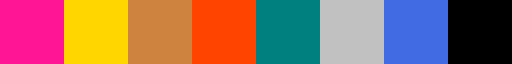

In [34]:
cmap

In [35]:
def make_image(dirname, save_filename, legend_filename,
              normalization_vector = np.array([4271.72225822, 4249.16076583, 4058.65912617, 4212.00589102]),
              ):
    dataset = FISHDataset(dirname, labels=labels)
    images_stack = []
    for channel in dataset.channel_names:
        images_stack.append(dataset[channel])
    
    images_stack = np.stack(images_stack, axis=0)
    n, height, width = images_stack.shape

    # calculate the average signal

    print("Normalization vector: ", normalization_vector)
    #normalization_vector = np.array( [ 6988.39795885, 6493.41761317, 10565.46357202, 7314.70841152])
    #print("Normalization vector: ", normalization_vector)
    images_stack = images_stack.reshape(4, -1)
    images_stack_normalized = images_stack - normalization_vector[:, None]
    images_stack_normalized = images_stack_normalized.T
    print("Image stack shape: ", images_stack_normalized.shape)
    
    class_img_predicted = clf.predict(images_stack_normalized)
    class_img_reshaped = class_img_predicted.reshape(height, width)
    unique, counts = np.unique(class_img_predicted, return_counts=True)

    print(f"Class numbers: {unique}")
    print(f"Counts: {counts}")

    class_img_show = np.array([[colors[i] for i in j] for j in class_img_reshaped])
    print(f"Class image shape: {class_img_show.shape}")
    
    plt.subplots(figsize=(12, 8))
    plt.imshow(class_img_show, cmap=cmap)
    plt.axis('off')
    #legend = plt.legend(handles=patches, ncol=8, loc="upper center")
    plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    plt.figure(figsize=(16, 2))
    legend = plt.legend(handles=patches, ncol=8, loc="upper center", frameon=False)

    def export_legend(legend, filename=legend_filename):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, bbox_inches=bbox, transparent=False)
        #plt.show()
        
    export_legend(legend)

```
make_image(directories['image1'],
           save_filename = SAVE_DIR + '/fig8/image1_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4313.62526486, 4351.15104429, 4206.1911008, 4123.51649682])
)
```

In [36]:

make_image(directories['image5'],
           save_filename = SAVE_DIR + '/fig8/image5_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4289.424, 4440.745, 4218.596 , 4049.294]),
)

Normalization vector:  [4289.424 4440.745 4218.596 4049.294]
Image stack shape:  (7947072, 4)
Class numbers: [0 1 2 3 4 5 6 7]
Counts: [  26988  629356      29    5251     298    1130  578667 6705353]
Class image shape: (1944, 4088, 3)


```
make_image(directories['image2'],
           save_filename = SAVE_DIR + '/fig8/image2_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4326.27224687, 4310.09326905, 4197.56158149, 4275.67799421])
)
```

In [37]:

make_image(directories['image6'],
           save_filename = SAVE_DIR + '/fig8/image6_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4770.425, 4250.041, 4179.332, 4691.710])
)

Normalization vector:  [4770.425 4250.041 4179.332 4691.71 ]
Image stack shape:  (8241408, 4)
Class numbers: [0 2 3 4 5 6 7]
Counts: [    111  559949       8  320088    1957   19076 7340219]
Class image shape: (2016, 4088, 3)


```
make_image(directories['image3'],
           save_filename = SAVE_DIR + '/fig8/image3_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4355.27135471, 4455.60567133, 4420.70555397, 4186.88742982])
)
```

In [38]:
make_image(directories['image7'],
           save_filename = SAVE_DIR + '/fig8/image7_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4611.910, 5680.618, 4315.598, 4222.574])
          )


Normalization vector:  [4611.91  5680.618 4315.598 4222.574]
Image stack shape:  (8314992, 4)
Class numbers: [0 1 3 4 5 6 7]
Counts: [ 606690    3460 2132838   34196   61768   15999 5460041]
Class image shape: (2034, 4088, 3)


```
make_image(directories['image4'],
           save_filename = SAVE_DIR + '/fig8/image4_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([5671.72225822, 8249.16076583, 12258.65912617, 20212.00589102])
)
```

In [39]:

make_image(directories['image8'],
           save_filename = SAVE_DIR + '/fig8/image8_8c.svg',
           legend_filename= SAVE_DIR + '/fig8/legend.svg',
           normalization_vector=np.array([4491.67772512, 4257.02611073, 4332.77625717, 4275.51570016])
)

Normalization vector:  [4491.67772512 4257.02611073 4332.77625717 4275.51570016]
Image stack shape:  (8128224, 4)
Class numbers: [0 1 2 3 4 5 6 7]
Counts: [ 417006   13846     256   15757    5512  174083  180273 7321491]
Class image shape: (2004, 4056, 3)


#### Fig 8d

### Cell counts  are written in growth rate bundle.

#### First experiment K.pneumoniae and S.aureus Ciprofloxacin 1ug/ml

In [40]:
from narsil2.mm.growth import growth_rate_pickles
species_full_names = {
    'ecoli':'E.coli',
    'kpneumoniae':'K.pneumoniae',
    'paeruginosa':'P.aeruginosa',
    'efaecalis':'E.faecalis',
    'abaumanii':  'A.baumannii',
    'pmirbalis': 'P.mirabilis',
    'saureus': 'S.aureus',
}

In [42]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirabilis', 'S.aureus']
No_Ab_Positions = list(range(101, 181))
Ab_Positions = list(range(201, 281))
analysis_dir = '/mnt/sda2/Praneeth/ASTFISH/analysis_rev/EXP-22-BV6194 AST FISH 220210/'
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': '../../saved_models/tracker_model.pth',
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 281),
    'num_channels': 32,
    'growth_type': 'rolling'
}
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=1,
                        antibiotic_name='Ciprofloxacin',
                       n_frames=30)

labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(int(g.No_Ab_Clean_GrowthRates[species][2][4]))
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.ylabel("Number of cells detected")
plt.yticks([50] + list(np.arange(100, 2500, 500)))
for i in range(len(species_list)):
    plt.text(i, species_counts[i], species_counts[i], ha = 'center')
plt.show()
save_filename = SAVE_DIR + '/fig8/counts_8d_first.svg'
plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

#### Second experiment P.aeruginosa and A.baumannii Gentamycin 2ug/ml

In [43]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirabilis', 'S.aureus']
No_Ab_Positions = list(range(101, 181))
Ab_Positions = list(range(201, 281))
analysis_dir = '/mnt/sda2/Praneeth/ASTFISH/analysis_rev/EXP-22-BV6196 AST FISH 220214/'
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': '../../saved_models/tracker_model.pth',
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 281),
    'num_channels': 32,
    'growth_type': 'rolling'
}

g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=2,
                        antibiotic_name='Gentamycin',
                       n_frames=30)


labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(int(g.No_Ab_Clean_GrowthRates[species][2][4]))
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.ylabel("Number of cells detected")
#plt.axhline(y=50, linestyle='--', color='r', label='50')
#plt.yticks([50] + list(np.arange(100, 1500, 500)))
for i in range(len(species_list)):
    plt.text(i, species_counts[i], species_counts[i], ha = 'center')
plt.show()
save_filename = SAVE_DIR + '/fig8/counts_8d_second.svg'
plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

#### Third experiment E.coli and P.mirabilis Nitrofurantoin 32ug/ml

In [44]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirabilis', 'S.aureus']
No_Ab_Positions = list(range(101, 165))
Ab_Positions = list(range(201, 265))
analysis_dir = '/mnt/sda2/Praneeth/ASTFISH/analysis_rev/EXP-22-BV6197 AST FISH 220215/'
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates', # this name will also be used in growth rates
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': '../../saved_models/tracker_model.pth',
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 20,
    'flip_positions': range(201, 265),
    'num_channels': 42,
    'growth_type': 'ratio'
}
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=32,
                        antibiotic_name='Nitrofurantoin',
                       n_frames=30)


labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(int(g.No_Ab_Clean_GrowthRates[species][2][4]))
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.ylabel("Number of cells detected")
#plt.axhline(y=50, linestyle='--', color='r', label='50')
#plt.yticks([50] + list(np.arange(100, 3000, 500)))
for i in range(len(species_list)):
    plt.text(i, species_counts[i], species_counts[i], ha = 'center')
plt.show()
save_filename = SAVE_DIR + '/fig8/counts_8d_fourth.svg'
plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

/home/pk/anaconda3/envs/narsil2_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pk/anaconda3/envs/narsil2_env/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


#### Fourth Experiment E.coli and E.faecalis Vancomycin 4ug/ml

In [45]:
species_names = ['ecoli', 'kpneumoniae', 'paeruginosa', 'efaecalis', 'abaumanii', 'pmirbalis', 'saureus']
species_titles = ['E.coli', 'K.pneumoniae', 'P.aeruginosa', 'E.faecalis', 'A.baumannii', 'P.mirabilis', 'S.aureus']
No_Ab_Positions = list(range(101, 163))
Ab_Positions = list(range(201, 263))
analysis_dir = '/mnt/sda2/Praneeth/ASTFISH/analysis_rev/EXP-22-BZ0300 AST FISH 220422/'
tracking_parameters = {
    'move_iou_thres': 0.15,
    'div_iou_thres' : 0.15,
    'write_dir_names': {
        'channel_stacks': 'blobs',
        'growth_rates': 'growth_rates',
        'fluor_stacks': 'fish_channels',
    },
    'growth_type': 'rolling', # or 'ratio'
    'net_path': '../../saved_models/tracker_model.pth',
    'species_map': {
        'ecoli': ['cy3'],
        'kpneumoniae': ['cy3', 'cy5'],
        'paeruginosa': ['alexa488', 'texasred'],
        'efaecalis': ['alexa488', 'cy5'],
        'abaumanii': ['alexa488', 'cy3'],
        'pmirbalis': ['alexa488'],
        'saureus': ['cy5', 'texasred'],
    },
    'background_channel_no': 15,
    'flip_positions': range(201, 281),
    'num_channels': 32,
    'growth_type': 'rolling'
}
g = growth_rate_pickles(Path(analysis_dir), species_names, species_titles,
                        No_Ab_Positions=No_Ab_Positions, Ab_Positions=Ab_Positions,
                        tracking_parameters=tracking_parameters,
                        antibiotic_concentration=4,
                        antibiotic_name='Vancomycin',
                       n_frames=29)

labels_to_colors = {
    0: 'deeppink', # E.coli
    1: 'gold', # k.pneumoniae
    2: 'peru', # p.aeruginosa
    3: 'orangered', # e.faecalis
    4: 'teal', # A.baumanni
    5: 'silver', # p.mirabalis
    6: 'royalblue', # s.aureus 
    7: 'k' # background
}

labels = {
    0: 'E.coli',
    1: 'K.pneumoniae',
    2: 'P.aeruginosa',
    3: 'E.faecalis',
    4: 'A.baumannii',
    5: 'P.mirabilis',
    6: 'S.aureus',
    7: 'Background'
}
species_to_color = {
    'E.coli': 0,
    'K.pneumoniae': 1,
    'P.aeruginosa': 2,
    'E.faecalis': 3,
    'A.baumannii': 4,
    'P.mirabilis': 5,
    'S.aureus': 6,
}

species_list = []
species_counts = []
colors = []
for species in g.No_Ab_Clean_GrowthRates:
    species_list.append(species_full_names[species])
    species_counts.append(int(g.No_Ab_Clean_GrowthRates[species][2][4]))
    colors.append(labels_to_colors[species_to_color[species_full_names[species]]])
fig = plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.bar(np.arange(len(species_list)), species_counts, color=colors)
plt.xticks(np.arange(len(species_list)), species_list)
plt.ylabel("Number of cells detected")
#plt.axhline(y=50, linestyle='--', color='r', label='50')
#plt.yticks([50] + list(np.arange(100, 1300, 500)))
for i in range(len(species_list)):
    plt.text(i, species_counts[i], species_counts[i], ha = 'center')
plt.show()
save_filename = SAVE_DIR + '/fig8/counts_8d_third.svg'
plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)

### Saving the model to file

In [46]:
from joblib import dump, load

In [47]:
MODEL_SAVE_PATH = '../../saved_models/fish_classifier/seven_species_debugged_final.joblib'

In [48]:
dump(clf, MODEL_SAVE_PATH)